# Recovering regulation on Yeast

In this notebook we validate GIRAFFE on biological data, using an experimental dataset for
cell-cycle synchronized Baker’s yeast cells (Saccharomyces cerevisiae). This code reproduces the finding in Section 5.3 in the manuscript. 

## 1. Loading required packages and data

In [1]:
import giraffe
import matplotlib.pyplot as plt
from netZooPy.otter.otter import otter
from netZooPy.panda import Panda
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import torch
from data.yeast import preprocessing

In [2]:
preprocessing = True

In [3]:
if not preprocessing:
    preprocessing.generate_data()

In [4]:
expression = pd.read_csv("data/yeast/raw/YeastCCData_Expression.txt", sep = '\t', header = None).iloc[:, 1:]
motif_matrix = pd.read_csv("data/yeast/motif_matrix.txt", index_col = 0)
ppi = pd.read_csv("data/yeast/ppi.txt", index_col = 0)

## 2. Validation

To assess GIRAFFE's ability to recover the regulation matrix, we compute the AUC between the estimated GRN and a "gold standard" identified from ChIP-seq experiments. ChIP-seq exploits chromatin immunoprecipitation to determine which DNA fragments are enriched for a given protein. After applying a thresholding (p<0.001), the procedure yield which sequences are physically bound by a transcription factor. Note that in the validation, only the subset of edges in the "gold standard" are considered. 

In [5]:
def get_ground_truth_and_estimation(estimated_regulation):
    
    chip = pd.read_csv("data/yeast/raw/YeastCCData_ChIP.txt", sep = '\t', header = None)
    chip[chip[0] == "SIG1"] = "YER068W"
    chip[chip[0] == "RCS1"] = "YGL071W"
    chip[chip[0] == "RLR1"] = "YNL139C"
    chip[3] = 0
    
    to_drop = []
    for i in range(chip.shape[0]) :
            if (not type(chip[2].iloc[i]) == float):
                to_drop += [i] 
                continue
            if np.isnan(chip[2].iloc[i]) :
                continue
            if chip[2].iloc[i] >= 0.001 :
                chip[2].iloc[i] = 0
            else :
                chip[2].iloc[i] = 1
            chip[3].iloc[i] = estimated_regulation[chip[0].iloc[i]][chip[1].iloc[i]]
    
    chip = chip.drop(to_drop)
    chip = chip.dropna(axis = 0)     
    
    return chip[2].values.astype(int), chip[3].values

## 3. Estimating regulation with GIRAFFE and other baselines

We estimate regulation using GIRAFFE, and compute the AUROC against three baselines: PANDA [1], OTTER[2], and the motif. 

### 3.1 GIRAFFE

In [6]:
giraffe_regulation = giraffe.Giraffe(expression, motif_matrix.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0]), lr = 1e-8).get_regulation()
# giraffe_regulation = giraffe.Giraffe(expression, motif_matrix.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0]), regularization = 1e-11, lr = 1e-8).get_regulation() with SGD

In [7]:
ground_truth, pred_giraffe = get_ground_truth_and_estimation(pd.DataFrame(np.abs(giraffe_regulation), index = motif_matrix.index, columns = motif_matrix.columns))

### 3.2 OTTER

In [8]:
R_otter = otter(motif_matrix.T.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0]), np.corrcoef(expression.to_numpy()))

In [9]:
ground_truth, pred_otter = get_ground_truth_and_estimation(pd.DataFrame(np.abs(R_otter.T), index = motif_matrix.index, columns = motif_matrix.columns))

### 3.3 PANDA

In [10]:
panda_regulation = Panda(
        "data/yeast/raw/YeastCCData_Expression.txt",
        "data/yeast/raw/YeastCCData_Motif.txt",
        "data/yeast/PPI.txt",
        save_tmp=False,
        save_memory=False,
        remove_missing=False,
        keep_expression_matrix=False
    ).panda_network

Loading motif data ...
  Elapsed time: 0.07 sec.
Loading expression data ...
  Elapsed time: 0.04 sec.
Loading PPI data ...
Number of PPIs: 6330
  Elapsed time: 0.01 sec.
Calculating coexpression network ...
  Elapsed time: 0.19 sec.
Creating motif network ...
  Elapsed time: 0.12 sec.
Creating PPI network ...
  Elapsed time: 0.01 sec.
union data/yeast/raw/YeastCCData_Motif.txt data/yeast/raw/YeastCCData_Expression.txt data/yeast/PPI.txt False False False
Normalizing networks ...
  Elapsed time: 0.97 sec.
Running PANDA algorithm ...
Computing panda on CPU
step: 0, hamming: 1.205634443227705
step: 1, hamming: 0.4504696454572376
step: 2, hamming: 0.3331434266739424
step: 3, hamming: 0.2817836423766645
step: 4, hamming: 0.2493666826334308
step: 5, hamming: 0.22398085840134538
step: 6, hamming: 0.20169442721896658
step: 7, hamming: 0.18110946069424957
step: 8, hamming: 0.1617758476444492
step: 9, hamming: 0.14360705522723657
step: 10, hamming: 0.12665459539940513
step: 11, hamming: 0.11099

In [11]:
ground_truth, pred_panda = get_ground_truth_and_estimation(pd.DataFrame(panda_regulation.T, index = motif_matrix.index, columns = motif_matrix.columns))

### 3.4 Motif

In [12]:
ground_truth, pred_motif = get_ground_truth_and_estimation(pd.DataFrame(motif_matrix, index = motif_matrix.index, columns = motif_matrix.columns))

## 4. Plot

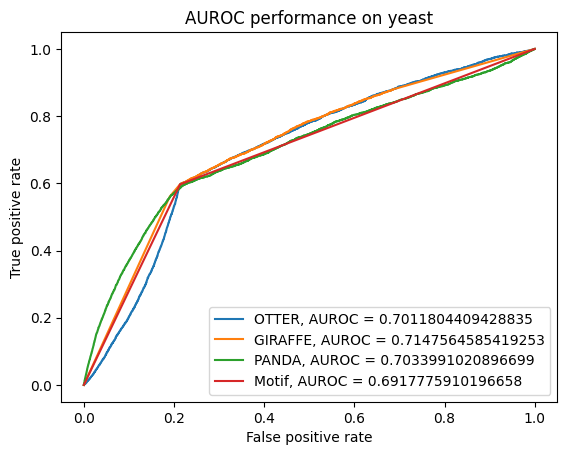

[0.7011804409428835,
 0.7147564585419253,
 0.7033991020896699,
 0.6917775910196658]

In [23]:
giraffe.utils.plot_auroc(ground_truth, 
                         [pred_otter, pred_giraffe, pred_panda, pred_motif], 
                         ["OTTER", "GIRAFFE", "PANDA", "Motif"],
                         "AUROC performance on yeast"
                        )

We observe that all three methods improve over the prior motif (AUROC=0.692). OTTER (AUROC=0.701) and PANDA (AUROC=0.703) perform similarly, while GIRAFFE has a higher score (AUROC=0.715) and is the only method that consistently dominates over the motif's ROC curve. 

## 4. Transcription factor knock outs

In [2]:
expression = pd.read_csv("data/YEAST/expression/TFKOexpressionData.csv", index_col = 0)
prior = pd.read_csv("data/YEAST/prior/S8_50-TF_ChIP-PC_binary_network_with_signs_from_ZEV.csv", index_col = 0).T
ppi = pd.read_csv("data/yeast/ppi.txt", index_col = 0)

In [3]:
tf = []
for p in prior.index:
    if p in ppi.index:
        tf.append(p)
E = pd.DataFrame(0, index = expression.index, columns = set(tf))
M = pd.DataFrame(0, index = prior.columns, columns = set(tf))
P = pd.DataFrame(0, index = tf, columns = set(tf))
for t in tf:
    E.loc[:, t] = expression.loc[:, t]
    M.loc[:, t] = prior.loc[t, :]
    P.loc[:, t] = ppi.loc[:, t]
E = E.loc[E.index.isin(prior.columns), :]
E.sort_index(axis = 1, inplace = True)
M.sort_index(axis = 1, inplace = True)
P.sort_index(axis = 0, inplace = True)
P.sort_index(axis = 1, inplace = True)
from sklearn.preprocessing import normalize
E = normalize(E, axis=0, norm='max')

In [4]:
def get_rank(TFA):
    res = []
    for i in range(TFA.shape[1]):
        scores = TFA[i, i]
        a = np.sort(TFA[:, i])
        res += [np.sum(scores > a)]
    return np.asarray(res)

model = giraffe.Giraffe(E, M.to_numpy(), P + np.eye(P.shape[0]))
R = model.get_regulation()
TFA = model.get_tfa()
rank = get_rank(TFA)
print(np.sum(rank == 0))
print(np.mean(rank))

31
8.166666666666666


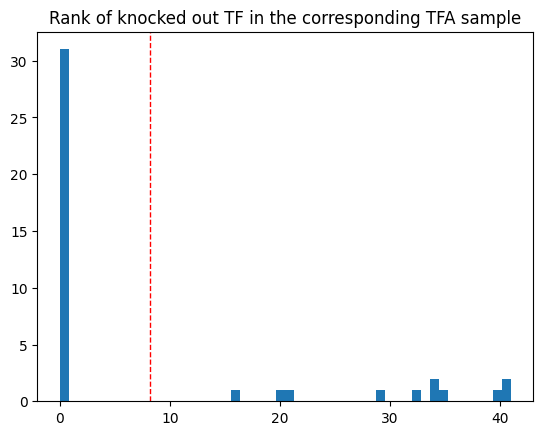

In [11]:
plt.hist(rank, bins = 50)
plt.title("Rank of knocked out TF in the corresponding TFA sample")
plt.axvline(np.mean(rank), color='red', linestyle='dashed', linewidth=1)

## References

[1] Glass K, Huttenhower C, Quackenbush J, Yuan GC. "Passing Messages Between Biological Networks to Refine Predicted Interactions", PLoS One, 2013 May 31;8(5):e64832

[2] Weighill, Deborah, et al. "Gene regulatory network inference as relaxed graph matching." Proceedings of the... AAAI Conference on Artificial Intelligence. AAAI Conference on Artificial Intelligence. Vol. 35. No. 11. NIH Public Access, 2021.